In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from torchmetrics.functional import r2_score as torch_r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the data

In [74]:
df = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/train.csv")

In [75]:
df.describe()

,Unnamed: 0,Completion_rate,Tuition_in_state,Tuition_out_state,Faculty_salary,Pell_grant_rate,SAT_average,ACT_50thPercentile,pct_White,pct_Black,pct_Hispanic,pct_Asian,Parents_middlesch,Parents_highsch,Parents_college
count,2364.00000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000
mean,1181.50000,0.539796,19759.014382,25244.847716,7974.087140,0.370193,1055.552876,23.100254,0.580825,0.146871,0.106338,0.046064,0.028537,0.303929,0.667534
std,682.57234,0.175897,12874.765104,9695.943019,2259.787691,0.142627,133.310358,3.437689,0.219298,0.198238,0.118509,0.062720,0.021679,0.080973,0.092202
min,0.00000,0.038000,480.000000,480.000000,3186.000000,0.083300,708.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.002952,0.075059,0.384661
25%,590.75000,0.414575,8113.750000,17791.750000,6416.500000,0.271675,972.000000,21.000000,0.477575,0.045000,0.035900,0.010575,0.015270,0.251640,0.602832
50%,1181.50000,0.528650,15022.000000,23803.000000,7528.500000,0.357600,1037.000000,23.000000,0.629800,0.076800,0.066900,0.021750,0.022839,0.314879,0.658168
75%,1772.25000,0.657000,29192.500000,30818.750000,9082.750000,0.446925,1115.250000,25.000000,0.743750,0.157225,0.127100,0.054400,0.034750,0.364107,0.729016
max,2363.00000,0.977900,55056.000000,55056.000000,22146.000000,0.996300,1519.000000,34.000000,0.962000,1.000000,0.948700,0.437100,0.201153,0.508948,0.915559


In [76]:
features = ['Tuition_in_state','Tuition_out_state','Faculty_salary','Pell_grant_rate','SAT_average','ACT_50thPercentile','pct_White','pct_Black','pct_Hispanic','pct_Asian','Parents_middlesch','Parents_highsch','Parents_college'] 
X = df[features]
y = df["Completion_rate"]

#Comment out when Sending to Kaggle
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Preprocessing

In [77]:
#Comment out when training
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X)

In [ ]:
#Comment out when sending to Kaggle
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [12]:
#Real X_Test
real_X_test = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/x_test.csv")
real_X_test = real_X_test.drop(columns=['Unnamed: 0'])
real_X_test = scaler.transform(real_X_test)

(2364, 13)

## Data Visualization to identify highly correlated features

In [63]:
#Obtain Correlation Coeff Matrix
corr_matrix = X.corr()
# # corr_array = corr_matrix['Completion_rate']
# #corr_array[(corr_array<-0.5) | (corr_array>0.5)]
# corr_array

In [62]:
corr_matrix

,Tuition_in_state,Tuition_out_state,Faculty_salary,Pell_grant_rate,SAT_average,ACT_50thPercentile,pct_White,pct_Black,pct_Hispanic,pct_Asian,Parents_middlesch,Parents_highsch,Parents_college
Tuition_in_state,1.000000,0.860870,0.298569,-0.375985,0.444843,0.456642,-0.011421,-0.199060,0.033140,0.251759,-0.105846,-0.426460,0.399412
Tuition_out_state,0.860870,1.000000,0.584519,-0.524262,0.649695,0.660598,-0.009354,-0.303906,0.087540,0.470226,-0.084076,-0.572338,0.522406
Faculty_salary,0.298569,0.584519,1.000000,-0.514413,0.718393,0.713896,-0.094360,-0.274768,0.168813,0.624502,-0.020837,-0.558185,0.495107
Pell_grant_rate,-0.375985,-0.524262,-0.514413,1.000000,-0.737485,-0.736816,-0.529219,0.669486,0.103810,-0.244992,0.356753,0.653620,-0.657901
SAT_average,0.444843,0.649695,0.718393,-0.737485,1.000000,0.986638,0.269222,-0.488081,-0.056479,0.479142,-0.234166,-0.744104,0.708543
ACT_50thPercentile,0.456642,0.660598,0.713896,-0.736816,0.986638,1.000000,0.269703,-0.487423,-0.054970,0.473344,-0.237970,-0.747646,0.712548
pct_White,-0.011421,-0.009354,-0.094360,-0.529219,0.269222,0.269703,1.000000,-0.643439,-0.441355,-0.332201,-0.490850,-0.201484,0.292357
pct_Black,-0.199060,-0.303906,-0.274768,0.669486,-0.488081,-0.487423,-0.643439,1.000000,-0.207920,-0.235069,-0.020668,0.283124,-0.243785
pct_Hispanic,0.033140,0.087540,0.168813,0.103810,-0.056479,-0.054970,-0.441355,-0.207920,1.000000,0.282688,0.723356,0.121471,-0.276756
pct_Asian,0.251759,0.470226,0.624502,-0.244992,0.479142,0.473344,-0.332201,-0.235069,0.282688,1.000000,0.315605,-0.296989,0.186615


From the Correlation Matrix:

Tuition_in_state and Tuition_out_state have high correlation (0.860870). SAT_average and ACT_50thPercentile have high correlation 0.986638.
Proposed Solution: Merging each set of highly correlated dataset by their averages to create 2 new features: Tuition_State_Ave and ACT_SAT_Ave

For Tuition_in_state and Tuition_out_state, it is reasonable to take the average as both features have similar data magitudes
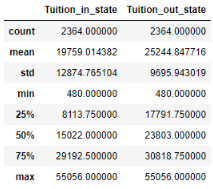

For SAT_average and ACT_50thPercentile, it is not straightforward as ACT_50thPercentile dataset values are several orders of magnitude less than SAT_average. Hence, the ACT_50thPercentile dataset is scaled up by 50 times before the average of both features is taken.
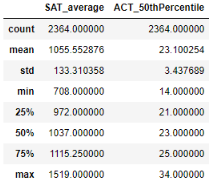

# Feature Engineering Attempt

In [5]:
def feature_eng(X): #Expecting a labelled DataFrame
    result = X.copy()
    result['Tuition_State_Ave']= result.loc[:, ['Tuition_in_state','Tuition_out_state']].sum(axis=1)
    result['Tuition_State_Ave'] = result['Tuition_State_Ave']/2
    del result['Tuition_in_state']
    del result['Tuition_out_state']
    
    result['ACT_50thPercentile'] = result['ACT_50thPercentile']*50
    result['ACT_SAT_Ave']= result.loc[:, ['SAT_average','ACT_50thPercentile']].sum(axis=1)
    result['ACT_SAT_Ave'] = result['ACT_SAT_Ave']/2
    
    del result['SAT_average']
    del result['ACT_50thPercentile']
    
    return result
    

In [78]:
feateng_df = feature_eng(df)
feateng_df

,Unnamed: 0,Completion_rate,Faculty_salary,Pell_grant_rate,pct_White,pct_Black,pct_Hispanic,pct_Asian,Parents_middlesch,Parents_highsch,Parents_college,Tuition_State_Ave,ACT_SAT_Ave
0,0,0.6552,4285,0.2531,0.3771,0.0612,0.0590,0.1345,0.011561,0.226397,0.762042,33560.0,1039.5
1,1,0.5246,9148,0.4752,0.2866,0.0331,0.4212,0.1011,0.107411,0.375165,0.517424,12963.0,1006.5
2,2,0.4030,7232,0.4668,0.3085,0.1426,0.2309,0.0149,0.091241,0.361314,0.547445,23144.0,1017.0
3,3,0.5472,9284,0.6369,0.1272,0.0572,0.6282,0.0557,0.163236,0.433621,0.403142,12190.0,888.5
4,4,0.8166,11984,0.1337,0.4251,0.0786,0.2268,0.0549,0.014868,0.186091,0.799041,47004.0,1411.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,2359,0.5311,6705,0.3402,0.6830,0.0544,0.0385,0.0225,0.019266,0.439450,0.541284,24090.0,974.5
2360,2360,0.5371,6340,0.4075,0.6215,0.1582,0.0883,0.0257,0.028593,0.404816,0.566591,36660.0,1091.5
2361,2361,0.3677,6689,0.5791,0.5842,0.2277,0.0569,0.0221,0.029851,0.370421,0.599729,30331.0,1054.5
2362,2362,0.5541,9312,0.2151,0.7347,0.0113,0.0718,0.0117,0.017512,0.259759,0.722729,10635.0,1151.0


In [79]:
feat_eng_features = ['Faculty_salary','Pell_grant_rate','pct_White','pct_Black','pct_Hispanic','pct_Asian','Parents_middlesch','Parents_highsch','Parents_college','Tuition_State_Ave','ACT_SAT_Ave'] 
X = feateng_df[feat_eng_features]
y = feateng_df["Completion_rate"]

#Comment out when Sending to Kaggle
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Eng Data Preprocessing

In [80]:
#Comment out when training
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X)

In [ ]:
#Comment out when sending to Kaggle
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
#Real X_Test
real_X_test = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/x_test.csv")
real_X_test = real_X_test.drop(columns=['Unnamed: 0'])
feateng_real_X_test = feature_eng(real_X_test)
real_X_test = scaler.transform(feateng_real_X_test)

## XGBOOST Hyperparameter tuning

### 1st Optimization Run

In [30]:
# xgb_param_grid = { 
#     'max_depth' : [6,20,50,80],
#     'learning_rate' :[0.01,0.1,1],
#     'colsample_bytree':[0.5,0.75,1],
#     'subsample': [0.5,0.75,1]
    
    
# }

# xgb_tuned = xgb.XGBRegressor()
# CV_xgb_REG = GridSearchCV(estimator=xgb_tuned, param_grid=xgb_param_grid, scoring ='neg_root_mean_squared_error')
# CV_xgb_REG.fit(X_train, y_train)
# CV_xgb_REG.best_params_

#Output:
# {'colsample_bytree': 0.75,
#  'learning_rate': 0.1,
#  'max_depth': 50,
#  'subsample': 0.5}

{'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 50,
 'subsample': 0.5}

### 2nd Optimization Run

In [31]:
# xgb_param_grid = { 
#     'max_depth' : [40,50,60],
#     'learning_rate' :[0.05,0.1,0.2,0.3],
#     'colsample_bytree':[0.65,0.75,0.85],
#     'subsample': [0.4,0.5,0.6]
    
    
# }

# xgb_tuned = xgb.XGBRegressor()
# CV_xgb_REG = GridSearchCV(estimator=xgb_tuned, param_grid=xgb_param_grid, scoring ='neg_root_mean_squared_error')
# CV_xgb_REG.fit(X_train, y_train)
# CV_xgb_REG.best_params_

#Output:
# {'colsample_bytree': 0.75,
#  'learning_rate': 0.05,
#  'max_depth': 40,
#  'subsample': 0.6}

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 40,
 'subsample': 0.6}

### 3rd Optimization Run

In [32]:
# xgb_param_grid = { 
#     'max_depth' : [15,20,25,30,35,40,45],
#     'learning_rate' :[0.03,0.05,0.07],
#     'subsample': [0.6],
#     'colsample_bytree': [0.75]
    
    
# }

# xgb_tuned = xgb.XGBRegressor()
# CV_xgb_REG = GridSearchCV(estimator=xgb_tuned, param_grid=xgb_param_grid, scoring ='neg_root_mean_squared_error')
# CV_xgb_REG.fit(X_train, y_train)
# CV_xgb_REG.best_params_

# {'colsample_bytree': 0.75,
#  'learning_rate': 0.05,
#  'max_depth': 25,
#  'subsample': 0.6}

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 25,
 'subsample': 0.6}

## n_estimator hypertuning using 3rd Optimization Run

n_estimators=100

In [33]:
# XGB_model = xgb.XGBRegressor(n_estimators=100,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9963796579068149

0.9963796579068149


In [34]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.0656162902046468

0.0656162902046468

n_estimators=200

In [37]:
# #200
# XGB_model = xgb.XGBRegressor(n_estimators=200,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9998873938181452

0.9998873938181452


In [38]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.0643443150838284

0.0643443150838284

n_estimators=300

In [39]:
# #300
# XGB_model = xgb.XGBRegressor(n_estimators=300,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9999881494947483

0.9999881494947483


In [40]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.06423473506438508

0.06423473506438508

n_estimators=400

In [41]:
# #400
# XGB_model = xgb.XGBRegressor(n_estimators=400,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9999915213055444

0.9999915213055444


In [42]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.06422398755935001

0.06422398755935001

n_estimators=500

In [45]:
# # #500
# XGB_model = xgb.XGBRegressor(n_estimators=500,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9999921918207533

0.9999921918207533


In [46]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.06422508035646513

0.06422508035646513

n_estimators=600

In [47]:
# #600
# XGB_model = xgb.XGBRegressor(n_estimators=600,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
# XGB_model.fit(X_train, y_train)
# xgb_r_sq = XGB_model.score(X_train, y_train)
# print(xgb_r_sq)

#0.9999924386105594

0.9999924386105594


In [48]:
# #Using model to obtain predictions for the Train Test split
# y_pred_TEST_XGB_model = XGB_model.predict(X_test)

# #Testing RMSE error for the Train Test split
# RMSE = mean_squared_error(y_test, y_pred_TEST_XGB_model, squared=False)
# RMSE

#0.06422550966550059

0.06422550966550059

Even though the training R_squared (0.9999924386105594) score of the model when n_estimators = 600 is greater than that of the training R_squared score (0.9999921918207533) of the model when n_estimators = 500 , the test RMSE (0.06422550966550059) of the model when n_estimators = 600 is greater than the test RMSE (0.06422508035646513) of the model when n_estimators = 500, this shows overfitting when n_estimators = 600 and the final model for the Feature_Engineering XGB Regressor model has the following parameters:

n_estimators=500,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75

## Using Final Model to make prediction for Kaggle Submission

In [81]:
real_X_test = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/x_test.csv")
real_X_test = real_X_test.drop(columns=['Unnamed: 0'])
feateng_real_X_test = feature_eng(real_X_test)
real_X_test = scaler.transform(feateng_real_X_test)

In [55]:
XGB_model = xgb.XGBRegressor(n_estimators=500,subsample = 0.6, max_depth = 25, learning_rate = 0.05, colsample_bytree = 0.75)
XGB_model.fit(X_train, y.to_numpy())
true_y_pred_TEST_XGB_tuned = XGB_model.predict(real_X_test)
print(true_y_pred_TEST_XGB_tuned)

[0.4102688  0.4604709  0.52974486 ... 0.55626214 0.6168811  0.6525417 ]


### Creating our submission

In [56]:
submission = pd.DataFrame.from_dict({'Completion_rate': true_y_pred_TEST_XGB_tuned})
submission

,Completion_rate
0,0.410269
1,0.460471
2,0.529745
3,0.428105
4,0.499727
...,...
1160,0.477834
1161,0.491224
1162,0.556262
1163,0.616881


In [57]:
submission.to_csv('submission.csv', index = True, index_label = "id") 

### To submit your submission

On the panel on your right, select the drop down "Submit to competition", and submit this notebook. Ensure that your submission is named ```submission.csv```!